In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import essentia.standard as es
import madmom
import IPython
import pickle
from pickle import load
from scipy.signal import find_peaks
import ipywidgets as widgets
from scipy import signal

In [2]:
# Onset detection using Spectral Onset Processor
def onset_SOP(audiofile):
    #Detection function
    fps = 200
    sodf = madmom.features.onsets.SpectralOnsetProcessor('superflux', diff_frames=20)
    sodf.processors[-1]  # doctest: +ELLIPSIS
    det_function = sodf(audiofile, fps = fps)
    det_function_norm = det_function/(max(det_function))

    #Dynamic threashold
    C_t = 0.99
    H = 100
    delta = 0.1

    din_th = np.zeros(len(det_function_norm))
    for m in range(H, len(det_function_norm)):
        din_th[m] = C_t*np.median(det_function_norm[m-H:m+H])+delta

    #Peak detection
    peaks, _ = find_peaks(det_function_norm, distance=fps/10, height = din_th)  
    onset_array = peaks/fps
    
    return onset_array

#Function definition
def sound_island(NRG):

    #Applying energy threshold to decide wave split boundaries
    split_decision_func = np.zeros_like(NRG)
    split_decision_func[NRG > 0.005] = 1
    #Setting segment boundaries
    #Inserting a zero at the beginning since we will decide the transitions using a diff function
    split_decision_func = np.insert(split_decision_func, 0, 0)
    diff_split_decision = np.diff(split_decision_func)
    #Start indexes: transition from 0 to 1
    start_indexes = np.nonzero(diff_split_decision > 0)[0] * hopSize
    #Stop indexes: transition from 1 to 0
    stop_indexes = np.nonzero(diff_split_decision < 0)[0] * hopSize
    return (split_decision_func, start_indexes, stop_indexes)

In [3]:
#Get all files with mp3 extension in the folder
path = 'test_audios'
audios = []
for file in os.listdir(path):
    if file.endswith(".mp3"):
        audios.append(os.path.join(path, file))

#Widget drop down menu
w = widgets.Dropdown(
    options=audios,
    value=audios[4],
    description='Song:',
)
w

Dropdown(description='Song:', index=4, options=('test_audios/Good_Cmaj_Sacle_legato.mp3', 'test_audios/MIDI_C_…

In [4]:
audiofile = w.value
#audiofile = 'C_Major_Scale_Sax_Legato3.mp3'
fs = 44100
# Loading audio file
x = es.MonoLoader(filename=audiofile)()
IPython.display.Audio(audiofile, rate=fs)

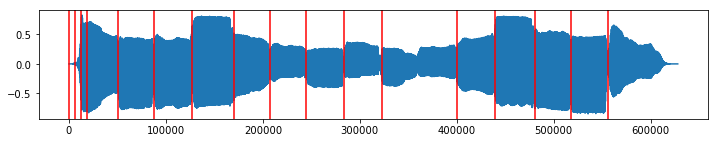

In [5]:
#Extract samples where the onsets happen
onset_array = onset_SOP(audiofile)*fs

#Plot Onsets
plt.rcParams['figure.figsize'] = (12, 2) # set plot sizes to something larger than default
plt.plot(x)
for onset in onset_array:
    plt.axvline(x=onset, color='red')

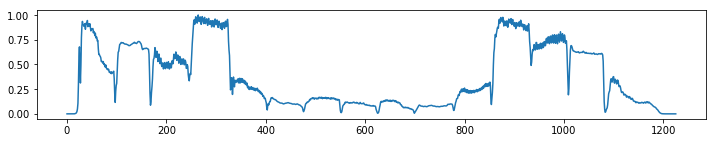

In [6]:
#Essentia energy computation
windowSize = 1024
hopSize = 512
NRG = [];
#Main windowing and feature extraction loop
for frame in es.FrameGenerator(x, frameSize = windowSize, hopSize = hopSize, startFromZero = True):
    NRG.append(es.Energy()(frame))
NRG = np.array(NRG)
NRG = NRG / np.max(NRG)
plt.plot(NRG)

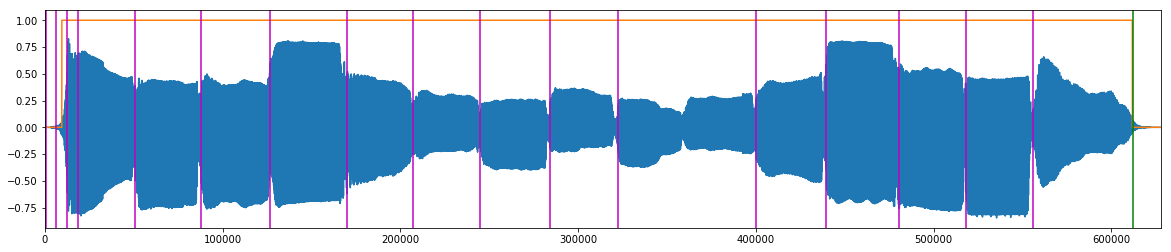

In [7]:
#Compute de decision function for the enregy threashold
split_decision_func, NRG_start_indexes, NRG_stop_indexes = sound_island(NRG)

#Upsample it to the same mumber of samples as the audio
is_there_NRG = np.around(signal.resample(split_decision_func, len(x)))

#Plot audio with onsets with the decision function
plt.rcParams["figure.figsize"] = (20,4)
plt.plot(x)
plt.plot(is_there_NRG)
plt.xlim(0, len(x))
for stop in NRG_stop_indexes:
    plt.axvline(x=stop, color='g')
for onset in onset_array:
    plt.axvline(x=onset, color='m')
    
    
    

In [8]:
#Delete the files that have been stored previously
def delete_files_in_dir(dir_name):
    for root, dirs, files in os.walk(dir_name):
        for file in files:
            file_name = os.path.join(root,file)
            os.remove(file_name);print(file_name, 'removed');

In [9]:
#Check if thedirectory already exists, of not, create a new one. If it exists and it is full, it deletes the files
segments_dir = 'segments'
if not os.path.exists(segments_dir):#creating the directory
    os.mkdir(segments_dir)
else:
    delete_files_in_dir(segments_dir)

segments/9.wav removed
segments/1.wav removed
segments/2.wav removed
segments/3.wav removed
segments/12.wav removed
segments/8.wav removed
segments/5.wav removed
segments/10.wav removed
segments/4.wav removed
segments/14.wav removed
segments/11.wav removed
segments/6.wav removed
segments/0.wav removed
segments/13.wav removed
segments/7.wav removed


In [10]:
NRG_stop_indexes

array([611840])

In [11]:
np.mean(is_there_NRG[200:134134])

0.9308241372616364

In [12]:
#Separate each note to a different file
file_count = 0
onset_shift = 2000
segment_files = []
x_seg=0
for i in range(len(onset_array)-1):
    start = int(onset_array[i])-onset_shift
    stop = int(onset_array[i+1])-onset_shift 
    if np.mean(is_there_NRG[start:stop])>0.5:#oly use segments that hafe enrgy (no between silences)
        if stop - start > fs/5:#only keep segments larger than 1/3 second
            x_seg = x[start:stop]
            #Final check for amplitude (to avoid silent segments selection due to noise in split function)
            if(np.max(np.abs(x_seg)) > 0.05):
                #Amplitude normalisation
                x_seg = x_seg / np.max(np.abs(x_seg))
                filename = os.path.join(segments_dir, str(file_count) + '.wav')
                es.MonoWriter(filename = filename, format = 'wav', sampleRate = fs)(x_seg)
                file_count +=1
                segment_files.append(filename)
            
print(len(segment_files),'segment files created')

13 segment files created


/home/ramon/envname/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/ramon/envname/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


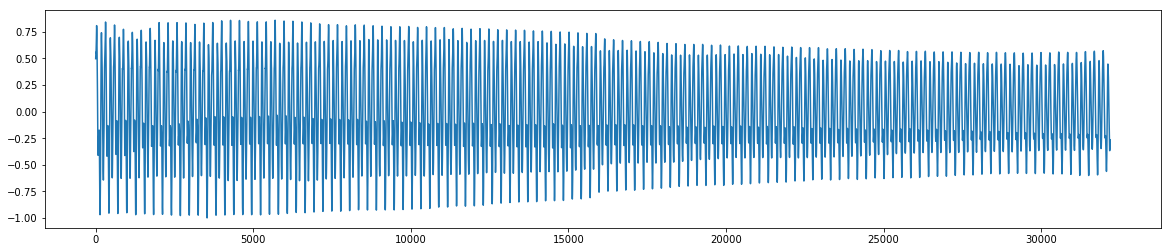

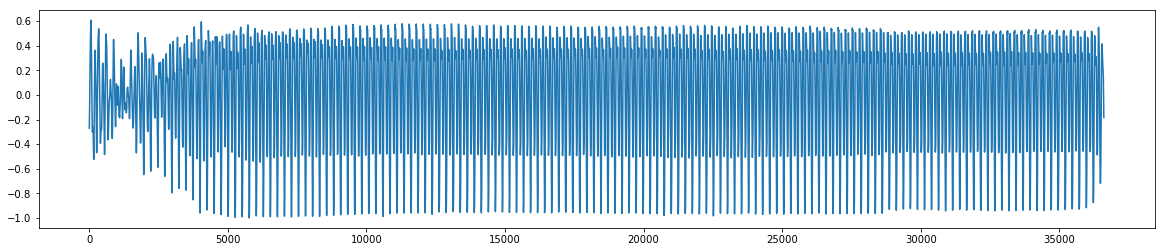

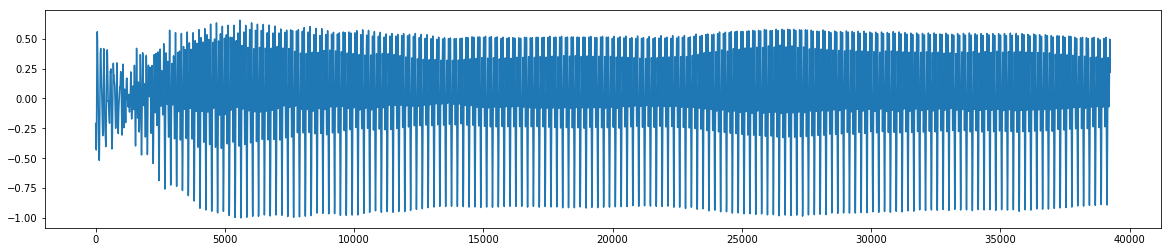

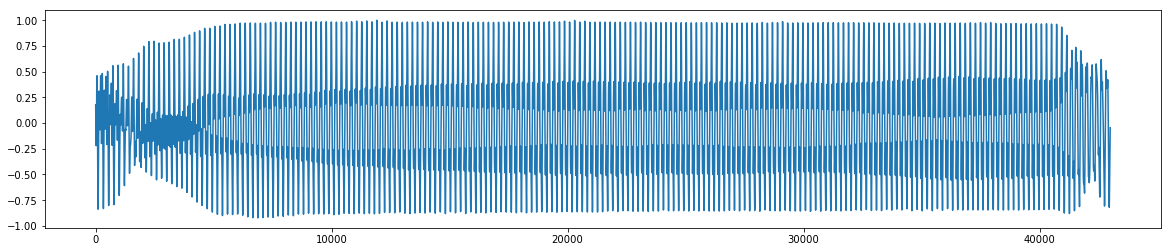

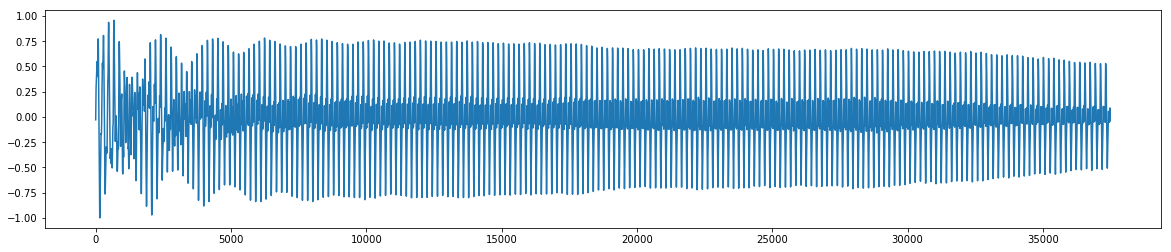

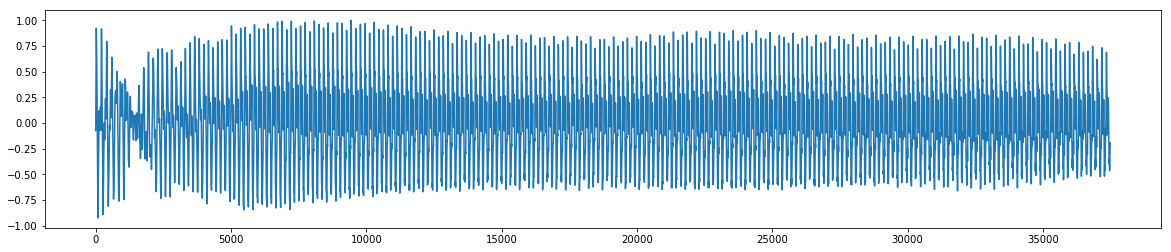

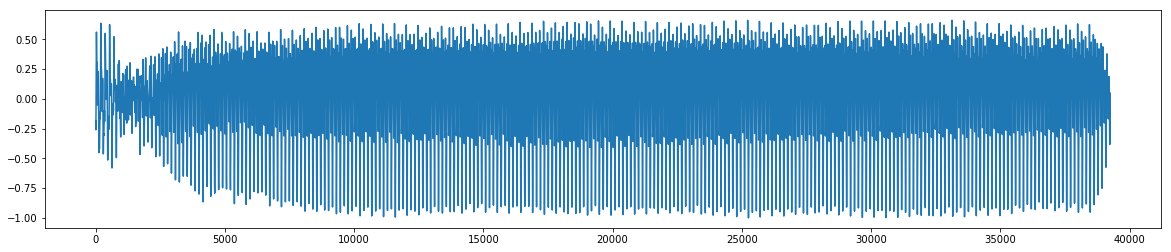

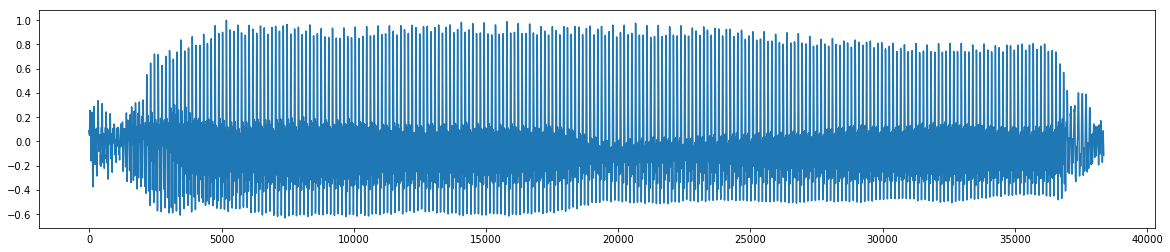

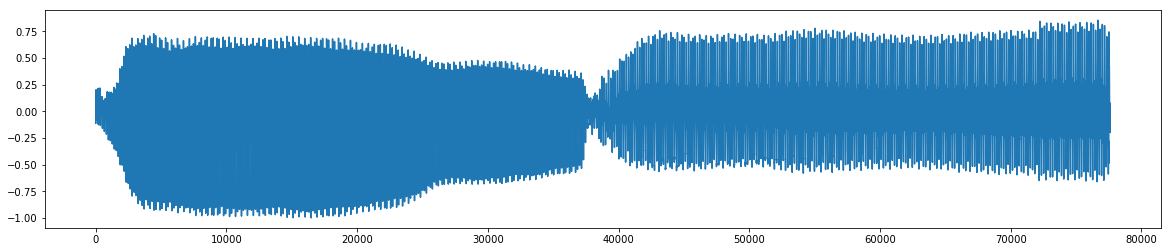

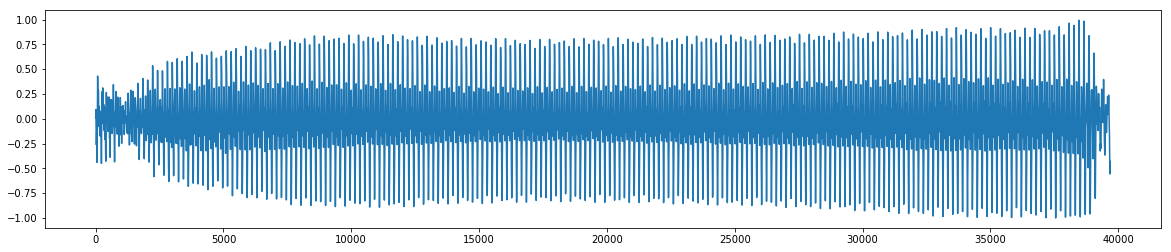

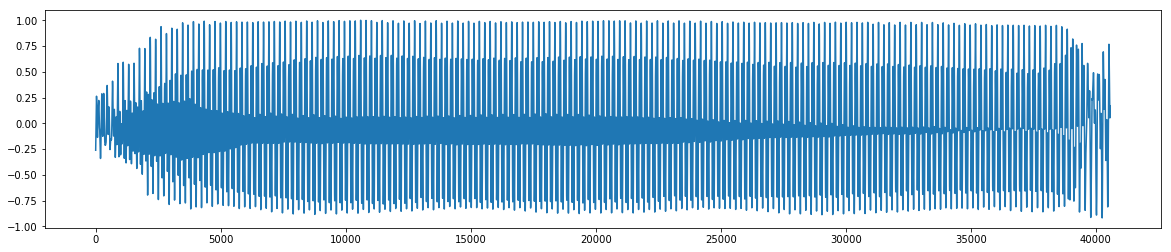

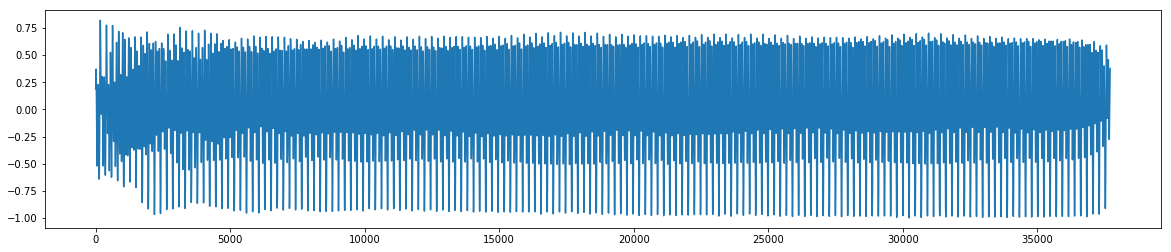

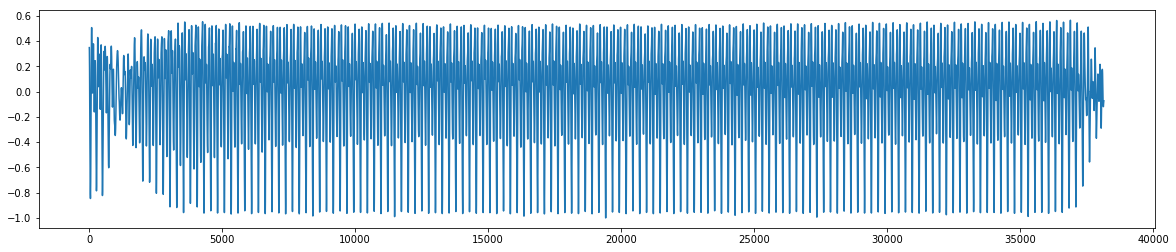

In [13]:
#Check the results
j = 0
for i in range(len(segment_files)):
    single_note = es.MonoLoader(filename=segment_files[i])()
    plt.plot(single_note)
    plt.show()

In [14]:
#Create a full directory path for each file of the input data
def get_file_paths(path):
    sound_files = os.listdir(path)
    segments_dir = []
    for i in range(len(sound_files)):
        filepath = os.path.join(path, sound_files[i])
        segments_dir.append(filepath)
    return segments_dir

In [15]:
#Create the files paths from the segment files
segments_files_path = get_file_paths(segments_dir)
segments_files_path

['segments/9.wav',
 'segments/1.wav',
 'segments/2.wav',
 'segments/3.wav',
 'segments/12.wav',
 'segments/8.wav',
 'segments/5.wav',
 'segments/10.wav',
 'segments/4.wav',
 'segments/11.wav',
 'segments/6.wav',
 'segments/0.wav',
 'segments/7.wav']